# Libraries and data load

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


# Data preparation

## Format column names

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

## Handle nulls

In [5]:
null_counts_per_column = df.isnull().sum()

for col in df.columns:
    if null_counts_per_column[col] > 0:
        print(f"{col} ({df[col].dtype}): {null_counts_per_column[col]} nulls")

lead_source (object): 128 nulls
industry (object): 134 nulls
annual_income (float64): 181 nulls
employment_status (object): 100 nulls
location (object): 63 nulls


In [6]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

In [7]:
df[numeric_cols] = df[numeric_cols].fillna(0.0)
df[non_numeric_cols] = df[non_numeric_cols].fillna('NA')

## Split data

In [8]:
target_column = 'converted'

y = df[target_column]
X = df.drop(columns=[target_column])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=1
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 877, Val: 292, Test: 293


# Question 1: ROC AUC feature importance

In [9]:
numeric_cols = [col for col in numeric_cols if col != target_column]

In [10]:
auc_scores = {}

for feat in numeric_cols:
    y_true = y_train
    score = X_train[feat]

    auc = roc_auc_score(y_true, score)
    # Invert if correlation is negative
    if auc < 0.5:
        auc = roc_auc_score(y_true, -score)
    auc_scores[feat] = auc


In [11]:
for k, v in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{k}: {v:.3f}")

number_of_courses_viewed: 0.765
interaction_count: 0.727
lead_score: 0.611
annual_income: 0.545


# Question 2: Training the model

In [12]:
dv = DictVectorizer(sparse=False)

train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

X_train_dv = dv.fit_transform(train_dicts)
X_val_dv = dv.transform(val_dicts)

In [13]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_dv, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [14]:
y_pred_val = model.predict_proba(X_val_dv)[:, 1]
auc = roc_auc_score(y_val, y_pred_val)
print(f"Validation AUC: {auc:.3f}")

Validation AUC: 0.794


# Question 3: Precision and Recall


In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [16]:
thresholds = np.arange(0.0, 1.0, 0.01)
precision = []
recall = []

for t in thresholds:
    predict_positive = (y_pred_val >= t)
    predict_negative = (y_pred_val < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision.append(tp / (tp + fp))
    recall.append(tp / (tp + fn))

C:\Users\nikko\AppData\Local\Temp\ipykernel_32992\1170482477.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))


In [17]:
precision = np.array(precision, dtype=float)
recall = np.array(recall, dtype=float)

# Create a mask to exclude invalid values
valid_mask = ~(
    np.isnan(precision) |
    np.isnan(recall) |
    np.isinf(precision) |
    np.isinf(recall)
)

# Apply mask to all arrays
precision_valid = precision[valid_mask]
recall_valid = recall[valid_mask]
thresholds_valid = thresholds[valid_mask]

# Compute intersection only on valid values
diff = np.abs(precision_valid - recall_valid)
best_idx = diff.argmin()
best_thresh = thresholds_valid[best_idx]

print(f"Precision and Recall intersect around threshold = {best_thresh:.3f}")


Precision and Recall intersect around threshold = 0.590


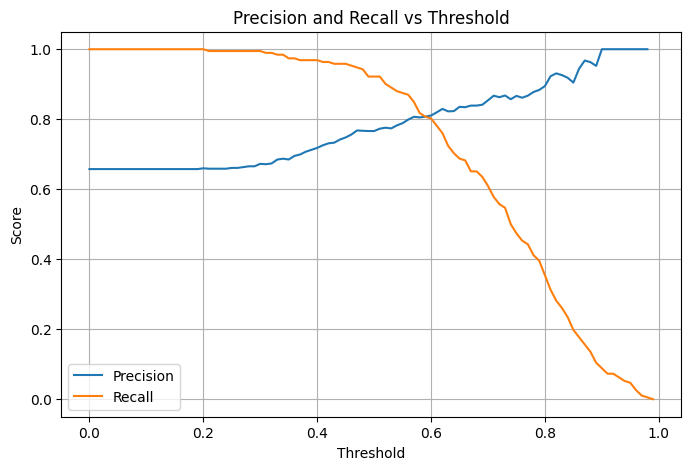

In [18]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Question 4: F1 score

In [19]:
f1_scores = []

for t in thresholds:
    predict_positive = (y_pred_val >= t)
    predict_negative = (y_pred_val < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
    f1_scores.append(f1)

C:\Users\nikko\AppData\Local\Temp\ipykernel_32992\1189708715.py:13: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


In [20]:
f1_scores = np.array(f1_scores)
best_idx = f1_scores.argmax()  # index of maximal F1
best_thresh = thresholds[best_idx]

print(f"Maximum F1 score is at threshold = {best_thresh:.3f}")

Maximum F1 score is at threshold = 0.470


# Question 5: 5-Fold CV

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

X_dicts = X_train.to_dict(orient='records')

for train_idx, val_idx in kf.split(X_train):
    X_tr = [X_dicts[i] for i in train_idx]
    X_val_fold = [X_dicts[i] for i in val_idx]
    
    y_tr = y_train.iloc[train_idx]
    y_val_fold = y_train.iloc[val_idx]

    dv = DictVectorizer(sparse=False)
    X_tr_dv = dv.fit_transform(X_tr)
    X_val_dv = dv.transform(X_val_fold)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_tr_dv, y_tr)

    y_pred_val = model.predict_proba(X_val_dv)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_val)
    auc_scores.append(auc)

In [22]:
auc_scores = np.array(auc_scores)
print("AUC per fold:", auc_scores)
print("Standard deviation:", auc_scores.std())

AUC per fold: [0.81172965 0.82324219 0.8364     0.83922922 0.82826667]
Standard deviation: 0.00983698319149229


# Question 6: Hyperparameter Tuning

In [23]:
C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

X_dicts = X_train.to_dict(orient='records')
y_array = y_train.values

In [24]:
results = []

for C in C_values:
    auc_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr = [X_dicts[i] for i in train_idx]
        X_val_fold = [X_dicts[i] for i in val_idx]
        
        y_tr = y_array[train_idx]
        y_val_fold = y_array[val_idx]

        # Fit DictVectorizer on training fold
        dv = DictVectorizer(sparse=False)
        X_tr_dv = dv.fit_transform(X_tr)
        X_val_dv = dv.transform(X_val_fold)

        # Train model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_tr_dv, y_tr)

        # Compute AUC
        y_pred_val = model.predict_proba(X_val_dv)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_val)
        auc_scores.append(auc)
    
    mean_auc = round(np.mean(auc_scores), 3)
    std_auc = round(np.std(auc_scores), 3)
    results.append((C, mean_auc, std_auc))


In [25]:
results_sorted = sorted(results, key=lambda x: (-x[1], x[2], x[0]))
best_C, best_mean, best_std = results_sorted[0]

print("Results per C:")
for r in results:
    print(f"C={r[0]}, mean AUC={r[1]}, std={r[2]}")
    
print(f"\nBest C: {best_C} with mean AUC={best_mean} and std={best_std}")

Results per C:
C=1e-06, mean AUC=0.548, std=0.042
C=0.001, mean AUC=0.872, std=0.016
C=1, mean AUC=0.828, std=0.01

Best C: 0.001 with mean AUC=0.872 and std=0.016
